---
title: Comparing Enformer and Borzoi prediction on GEUVADIS individuals
author: Sabrina Mi
date: 10/20/2023
---

Based off the limited results from personalized prediction across GEUVADIS individuals (N=455), I conclude that Borzoi does not outperform Enformer in predicting cross-population variation in gene expression. At the very bottom, I found that for most genes, Enformer had the best cross-population predictions out of all Borzoi estimates (from varying CAGE TSS window sizes).

In [6]:
import pandas as pd
enformer_corr_df = pd.read_csv("enformer_geuvadis_correlations.csv").dropna()
hg38_annot = hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t", index_col = "external_gene_name")
genes = set(enformer_corr_df['gene_names']).intersection(hg38_annot.index)
genes_annot = hg38_annot.loc[list(genes)]
sample_genes = genes_annot.sample(n=100)

In [7]:
intervals = []
for gene, annot in sample_genes.iterrows():
    interval = f"chr{annot['chromosome_name']}_{annot['transcription_start_site']}_{annot['transcription_start_site']}"
    intervals.append(interval)

In [8]:
with open("intervals.txt", "w") as f:
    f.write("\n".join(intervals))

### Submit PBS Job

```
#!/bin/bash
#PBS -A AIHPC4EDU
#PBS -q preemptable
#PBS -l walltime=6:00:00
#PBS -l select=2:ncpus=64:ngpus=16
#PBS -l filesystems=home:eagle
#PBS -N borzoi_across_geuvadis_parallel

module load conda
conda activate borzoi
cd /home/s1mi/Github/deep-learning-in-genomics/posts/2023-10-20-borzoi-vs-enformer-personalized-prediction

python3 personalized_prediction.py \
--intervals_file intervals.txt \
--fasta_file /home/s1mi/borzoi_tutorial/hg38.fa \
--vcf_dir /grand/TFXcan/imlab/data/1000G/vcf_snps_only \
--individuals_file individuals.txt \
--model_dir /home/s1mi/borzoi_tutorial \
--output_dir /eagle/AIHPC4Edu/sabrina/borzoi-personalized-predictions
```

In [41]:
import pandas as pd
import numpy as np
import os
import h5py
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.gene.txt", sep="\t", index_col="ensembl_gene_id")
seq_len = 524288
seq_out_len = 523264
predictions_dir = "/eagle/AIHPC4Edu/sabrina/borzoi-personalized-predictions"
with open("individuals.txt", "r") as f:
    individuals = f.read().splitlines()
with open("completed_intervals.txt", "r") as f:
    intervals = f.read().splitlines()
with open("intervals.txt", "r") as f:
    intervals.extend(f.read().splitlines()[:5]) # test on first few genes


In [43]:
gene_list = []
for interval in intervals:
    split_interval = interval.split("_")
    chr = split_interval[0][3:]
    tss = int(split_interval[1])
    gene = hg38_annot.index[(hg38_annot['chromosome_name'] == chr) & (hg38_annot['transcription_start_site'] == tss)]
    gene_list.append(gene.item())

In [44]:
CAGE_dict = {gene: [] for gene in gene_list}
for index, gene in enumerate(gene_list):
    interval = intervals[index]
    for individual in individuals: 
        predictions_file = os.path.join(predictions_dir, individual, f'{interval}_predictions.h5')
        if os.path.exists(predictions_file):
            with h5py.File(predictions_file, "r") as hf:
                haplo1 = np.mean(hf['haplotype1'][:, 3:7, :])
                haplo2 = np.mean(hf['haplotype2'][:, 3:7, :])
                prediction = (haplo1 + haplo2)/2
            CAGE_dict[gene].append(prediction)
        else:
            CAGE_dict[gene].append(np.nan)

In [45]:
geuvadis_gex = pd.read_csv("/lus/grand/projects/TFXcan/imlab/data/1000G/expression/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz", sep="\t")
geuvadis_gex['TargetID'] = geuvadis_gex['TargetID'].apply(lambda gene: gene.split('.')[0])
geuvadis_gex.set_index('TargetID', inplace=True)

In [46]:
expr_dict = {}
for gene in gene_list:
    observed = pd.to_numeric(geuvadis_gex.loc[gene][individuals])
    expr_df = pd.DataFrame({'Observed': observed, "Predicted": CAGE_dict[gene]}, index = individuals)
    expr_dict[gene] = expr_df.dropna()

In [47]:
pearson_corr_by_gene = pd.DataFrame(columns=["Pearson R", "P-value"], index = gene_list)
for gene in gene_list:
    corr, pval = stats.pearsonr(expr_dict[gene]["Observed"], expr_dict[gene]["Predicted"])
    pearson_corr_by_gene.loc[gene] = [corr, pval]


In [48]:
spearman_corr_by_gene = pd.DataFrame(columns=["Spearman R", "P-value"], index = gene_list)
for gene in gene_list:
    corr, pval = stats.spearmanr(expr_dict[gene]["Observed"], expr_dict[gene]["Predicted"])
    spearman_corr_by_gene.loc[gene] = [corr, pval]

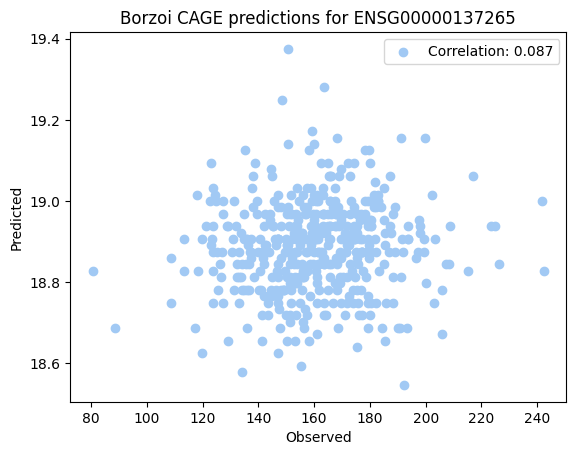

In [60]:
colors = sns.color_palette("pastel")
gex_df = expr_dict['ENSG00000137265']
corr, pval = stats.pearsonr(gex_df['Observed'], gex_df['Predicted'])
plt.scatter(gex_df['Observed'], gex_df['Predicted'], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")


# Add labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Borzoi CAGE predictions for ENSG00000137265")

# Show the plot
plt.legend()
plt.show()

ENSG00000137265 was the best performing gene (both for Spearman and Pearson R) for Borzoi's personalized prediction. 


## Compare Correlations to Enformer


In [61]:
enformer_corr_df = pd.read_csv("enformer_geuvadis_correlations.csv").dropna()
enformer_corr = []
for gene in gene_list:
    gene_name = hg38_annot.loc[gene]['external_gene_name']
    corr = enformer_corr_df['ge'][enformer_corr_df['gene_names'] == gene_name]
    enformer_corr.append(corr.item())

In [62]:
spearman_corr_by_gene["Enformer"] = enformer_corr
spearman_corr_by_model = spearman_corr_by_gene.rename(columns={"Spearman R": "Borzoi"}).drop(columns=["P-value"])


In [63]:
spearman_corr_by_model.head()

,Borzoi,Enformer
ENSG00000176058,-0.005758,-0.027832
ENSG00000156931,-0.075927,0.051405
ENSG00000118804,0.027522,0.004061
ENSG00000076924,0.058653,0.324224
ENSG00000167562,-0.027883,0.062367


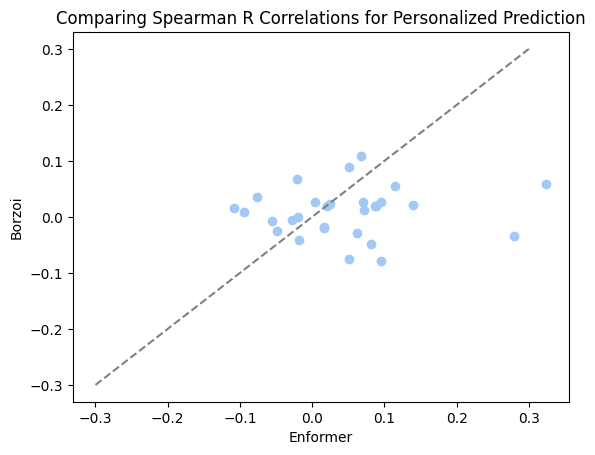

In [64]:
colors = sns.color_palette("pastel")
plt.scatter(spearman_corr_by_model['Enformer'], spearman_corr_by_model['Borzoi'], marker='o', color=colors[0])
line = np.linspace(-0.3, 0.3)
plt.plot(line, line, label='y = x', color='gray', linestyle='--')
# Add labels and title
plt.xlabel("Enformer")
plt.ylabel("Borzoi")
plt.title("Comparing Spearman R Correlations for Personalized Prediction")

plt.show()

### Bin Sizing

We used a 4 bin window centered at the TSS for each CAGE computation, we want to see which bin width gives the best estimate.

In [65]:
CAGE_dicts = [{gene: [] for gene in gene_list} for i in range(5)]
for index, gene in enumerate(gene_list):
    interval = intervals[index]
    for individual in individuals: 
        predictions_file = os.path.join(predictions_dir, individual, f'{interval}_predictions.h5')
        if os.path.exists(predictions_file):
            with h5py.File(predictions_file, "r") as hf:
                for i in range(5): 
                    haplo1 = np.mean(hf['haplotype1'][:, 4-i:6+i, :])
                    haplo2 = np.mean(hf['haplotype2'][:, 4-i:6+i, :])
                    prediction = (haplo1 + haplo2)/2
                    CAGE_dicts[i][gene].append(prediction)
        else:
            for i in range(5):
                CAGE_dicts[i][gene].append(np.nan)
    

In [66]:
spearman_corr_by_bin_size = pd.DataFrame({"Enformer": enformer_corr}, index=gene_list)
for i in range(5):
    results =[]
    for gene in gene_list:
        observed = pd.to_numeric(geuvadis_gex.loc[gene][individuals])
        predicted = CAGE_dicts[i][gene]
        corr, _ = stats.spearmanr(observed, predicted)
        results.append(corr)
    spearman_corr_by_bin_size[f'Borzoi, {2*(i+1)} bins'] = results


In [58]:
def histogram(x, title):
    plt.hist(x, bins=10, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
    plt.title(title)
    plt.xlabel('Spearman Correlations')
    plt.ylabel('Frequency')
    mean = np.mean(x)
    plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
    plt.legend()

    # Display the plot
    plt.show()

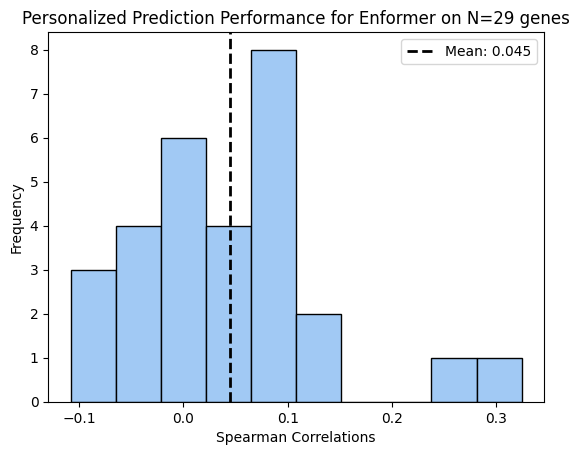

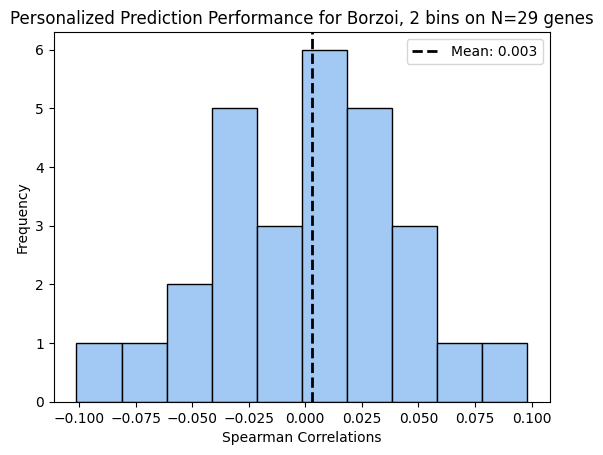

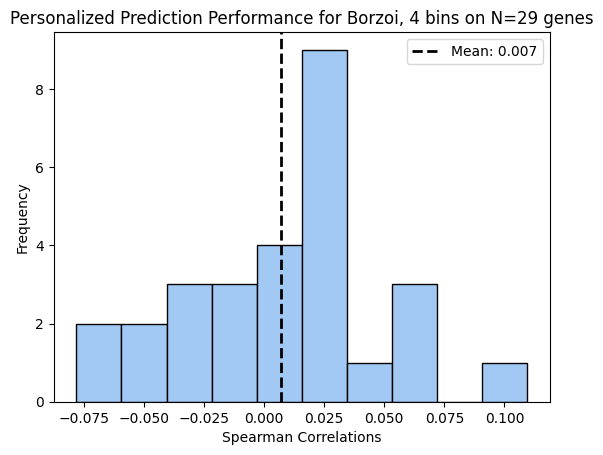

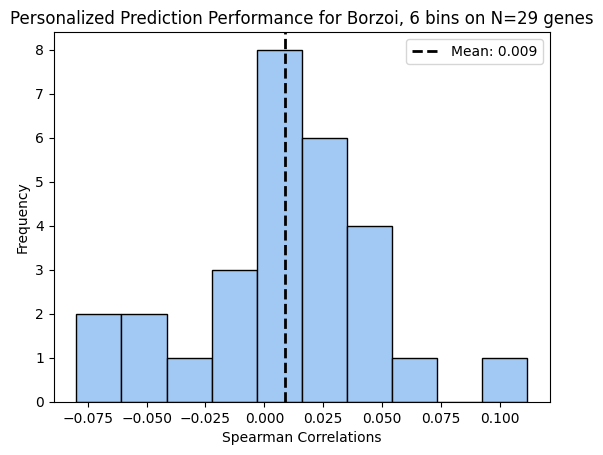

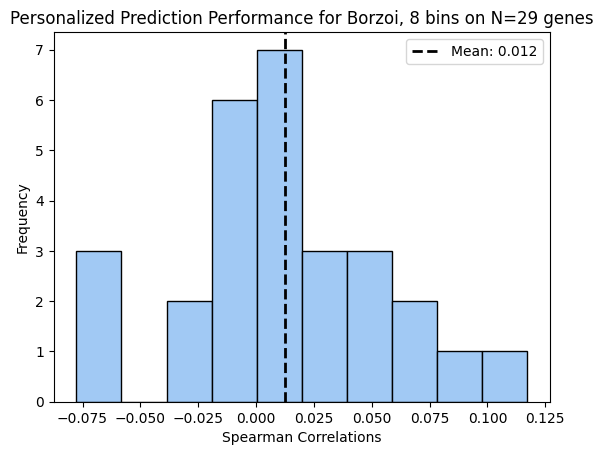

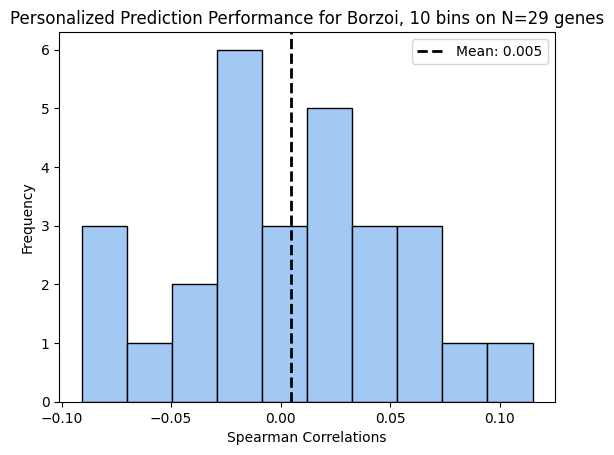

In [67]:
for column in spearman_corr_by_bin_size:
    n = len(gene_list)
    x = spearman_corr_by_bin_size[column]
    histogram(x, title=f'Personalized Prediction Performance for {column} on N={n} genes')

In [39]:
model_perf_dict = {column: 0 for column in spearman_corr_by_bin_size}
for index, row in spearman_corr_by_bin_size.iterrows():
    best_model = spearman_corr_by_bin_size.loc[index].idxmax()
    model_perf_dict[best_model] += 1
model_abs_perf_dict = {column: 0 for column in spearman_corr_by_bin_size}
for index, row in spearman_corr_by_bin_size.iterrows():
    best_model = spearman_corr_by_bin_size.abs().loc[index].idxmax()
    model_abs_perf_dict[best_model] += 1

In [40]:
print("Highest Correlation Model:")
print(model_perf_dict)
print("Highest Absolute Valued Correlation Model:")
print(model_abs_perf_dict)

Highest Correlation Model:
{'Enformer': 18, 'Borzoi, 2 bins': 4, 'Borzoi, 4 bins': 1, 'Borzoi, 6 bins': 2, 'Borzoi, 8 bins': 2, 'Borzoi, 10 bins': 1}
Highest Absolute Valued Correlation Model:
{'Enformer': 18, 'Borzoi, 2 bins': 3, 'Borzoi, 4 bins': 2, 'Borzoi, 6 bins': 1, 'Borzoi, 8 bins': 3, 'Borzoi, 10 bins': 1}


These plots suggest that averaging an 8-bin window (equivalent to 2 Enformer bins) might be the best method to estimate gene expression, but not by much:

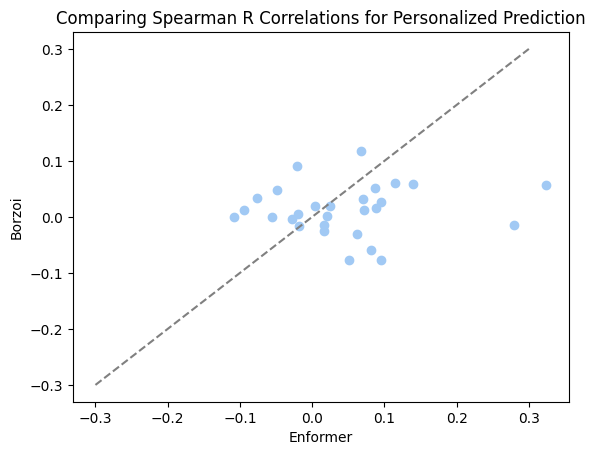

In [68]:
colors = sns.color_palette("pastel")
plt.scatter(spearman_corr_by_bin_size['Enformer'], spearman_corr_by_bin_size['Borzoi, 8 bins'], marker='o', color=colors[0])
line = np.linspace(-0.3, 0.3)
plt.plot(line, line, label='y = x', color='gray', linestyle='--')
# Add labels and title
plt.xlabel("Enformer")
plt.ylabel("Borzoi")
plt.title("Comparing Spearman R Correlations for Personalized Prediction")

plt.show()